# Demo for using the code base

## We load the different packages

In [47]:
import pandas as pd, datetime as dt, matplotlib.pyplot as plt, numpy as np, streamlit as st, os, sys
import py_vollib_vectorized

from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_vollib.black_scholes.greeks.analytical import delta

%matplotlib inline 

In [2]:
# importing functions from the code base
base_path = os.path.abspath(os.path.join('..'))
print(base_path)
if base_path not in sys.path:
    sys.path.append(base_path)
    
import src.api as api

/Users/nicolas/Projects/crypto_option_dashboard


# FEEDBACK

The notebook needs to be clean:
    
1) Inputs
a) User enters the various inputs
b) The inputs are checked (no expiry in the past, no negative strike, that kind of thing)

2) Calculations
3) Plot the results

## Inputs

In [53]:
underlying = "BTC"  # Values can be 'BTC' or 'ETH'
callOrPut = "Call"  # Values can be 'Call' or 'Put'

## Getting the instruments

The following function allow us to get the instruments available in Deribit

In [4]:
import nest_asyncio
nest_asyncio.apply()
instruments = api.get_instruments(currency=underlying, kind="option", expired=False)
instruments.head()

,tick_size,taker_commission,strike,settlement_period,rfq,quote_currency,option_type,min_trade_amount,maker_commission,kind,is_active,instrument_name,expiration_timestamp,creation_timestamp,contract_size,block_trade_commission,base_currency,creation_time,expiration_time
0,0.0005,0.0003,30000.0,month,False,BTC,call,0.1,0.0003,option,True,BTC-24JUN22-30000-C,1656057600000,1627994072000,1.0,0.00015,BTC,2021-08-03 13:34:32,2022-06-24 09:00:00
1,0.0005,0.0003,45000.0,month,False,BTC,put,0.1,0.0003,option,True,BTC-25MAR22-45000-P,1648195200000,1628197380000,1.0,0.00015,BTC,2021-08-05 22:03:00,2022-03-25 08:00:00
2,0.0005,0.0003,45000.0,day,False,BTC,put,0.1,0.0003,option,True,BTC-10FEB22-45000-P,1644480000000,1644307860000,1.0,0.00015,BTC,2022-02-08 08:11:00,2022-02-10 08:00:00
3,0.0005,0.0003,55000.0,month,False,BTC,call,0.1,0.0003,option,True,BTC-24JUN22-55000-C,1656057600000,1629483660000,1.0,0.00015,BTC,2021-08-20 19:21:00,2022-06-24 09:00:00
4,0.0005,0.0003,300000.0,month,False,BTC,call,0.1,0.0003,option,True,BTC-30SEP22-300000-C,1664524800000,1634315520000,1.0,0.00015,BTC,2021-10-15 17:32:00,2022-09-30 09:00:00


In [39]:
instruments.expiration_time.sort_values().unique()

array(['2022-02-09T08:00:00.000000000', '2022-02-10T08:00:00.000000000',
       '2022-02-11T08:00:00.000000000', '2022-02-18T08:00:00.000000000',
       '2022-02-25T08:00:00.000000000', '2022-03-25T08:00:00.000000000',
       '2022-04-29T09:00:00.000000000', '2022-06-24T09:00:00.000000000',
       '2022-09-30T09:00:00.000000000', '2022-12-30T08:00:00.000000000'],
      dtype='datetime64[ns]')

#### What month are we looking for?

In [5]:
# In 3 days, what month is it?
desired_month = (dt.datetime.now() + dt.timedelta(days=3)).month

In [6]:
# Get the last option expiring on that month
expiry_dates = instruments.expiration_time.unique()
expiry_months = expiry_dates.astype('datetime64[M]').astype(int) % 12 + 1

month_end_expiry = np.datetime64(dt.datetime.now())

for i in range(0, len(expiry_dates)):
    if expiry_months[i] == desired_month and expiry_dates[i] > month_end_expiry:
        month_end_expiry =  expiry_dates[i]

<AxesSubplot:>

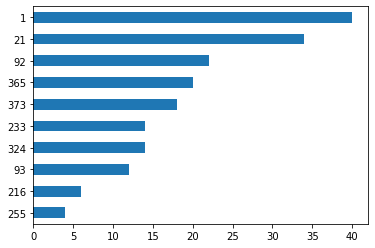

In [7]:
# get all options type for the closest settlement time
date_of_interest = instruments.expiration_time.min()
instruments["life_of_option"] = instruments.expiration_time - instruments.creation_time
instruments["life_of_option"].dt.days.value_counts().head(10).sort_values().plot(kind = 'barh')
#instruments.sort_values(by=["life_of_option","expiration_time"],ascending=[0,1]).head()

In [8]:
instruments_21t = instruments.loc[instruments.life_of_option.dt.days == 21]
instruments_21t.head()

,tick_size,taker_commission,strike,settlement_period,rfq,quote_currency,option_type,min_trade_amount,maker_commission,kind,is_active,instrument_name,expiration_timestamp,creation_timestamp,contract_size,block_trade_commission,base_currency,creation_time,expiration_time,life_of_option
15,0.0005,0.0003,36000.0,week,False,BTC,put,0.1,0.0003,option,True,BTC-18FEB22-36000-P,1645171200000,1643270402000,1.0,0.00015,BTC,2022-01-27 08:00:02,2022-02-18 08:00:00,21 days 23:59:58
23,0.0005,0.0003,50000.0,week,False,BTC,call,0.1,0.0003,option,True,BTC-18FEB22-50000-C,1645171200000,1643293140000,1.0,0.00015,BTC,2022-01-27 14:19:00,2022-02-18 08:00:00,21 days 17:41:00
27,0.0005,0.0003,36000.0,week,False,BTC,call,0.1,0.0003,option,True,BTC-18FEB22-36000-C,1645171200000,1643270402000,1.0,0.00015,BTC,2022-01-27 08:00:02,2022-02-18 08:00:00,21 days 23:59:58
29,0.0005,0.0003,45000.0,week,False,BTC,put,0.1,0.0003,option,True,BTC-11FEB22-45000-P,1644566400000,1642665900000,1.0,0.00015,BTC,2022-01-20 08:05:00,2022-02-11 08:00:00,21 days 23:55:00
36,0.0005,0.0003,46000.0,week,False,BTC,put,0.1,0.0003,option,True,BTC-11FEB22-46000-P,1644566400000,1642690620000,1.0,0.00015,BTC,2022-01-20 14:57:00,2022-02-11 08:00:00,21 days 17:03:00


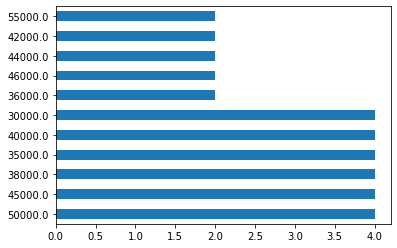

In [9]:
instruments_21t.strike.value_counts().plot(kind='barh');

In [50]:
temp = dt.datetime.now()
today_dt = dt.datetime(year=temp.year, month=temp.month, day=temp.day, hour=temp.hour, minute=temp.minute)

ts_today = dt.datetime.timestamp(today_dt) * 1000
spot_ohlcv = api.get_historical_data(ts_today, ts_today, underlying + "-PERPETUAL", "1D")

spot = (spot_ohlcv['open'][0] + spot_ohlcv['close'][0] + spot_ohlcv['high'][0] + spot_ohlcv['low'][0]) / 4

In [51]:
spot

43876.125

In [54]:
desired_option_type = callOrPut.lower()

In [13]:
# Find the closest strike from the current spot among the ones available

In [14]:
strikes = instruments.loc[instruments['expiration_time'] == month_end_expiry].loc[instruments['option_type'] == desired_option_type].strike.unique()
desired_strike = min(strikes, key=lambda x:abs(x-spot))

In [15]:
instrument_data = instruments.loc[(instruments.expiration_time == month_end_expiry) 
                                  & (instruments.option_type == desired_option_type) 
                                  & (instruments.strike == desired_strike)]
instrument_data

,tick_size,taker_commission,strike,settlement_period,rfq,quote_currency,option_type,min_trade_amount,maker_commission,kind,is_active,instrument_name,expiration_timestamp,creation_timestamp,contract_size,block_trade_commission,base_currency,creation_time,expiration_time,life_of_option
162,0.0005,0.0003,45000.0,month,False,BTC,call,0.1,0.0003,option,True,BTC-25FEB22-45000-C,1645776000000,1637740802000,1.0,0.00015,BTC,2021-11-24 08:00:02,2022-02-25 08:00:00,92 days 23:59:58


We now have an option that we want to backtest.
In the next step we will pull the data for this option.

## Getting the historical data

In [16]:
ts_creation = dt.datetime.timestamp(dt.datetime.fromtimestamp(instrument_data["creation_timestamp"].values[0]/1000).replace(second = 0, microsecond = 0)) * 1000
ts_expiration = dt.datetime.timestamp(dt.datetime.fromtimestamp(instrument_data["expiration_timestamp"].values[0]/1000).replace(second = 0, microsecond = 0)) * 1000

In [17]:
time_period = '1D'

option_data = api.get_historical_data(ts_creation,
                                      ts_expiration,
                                      instrument_data["instrument_name"].iloc[0],
                                      time_period)
option_data.head(3)

,volume,ticks,status,open,low,high,cost,close,timestamp
0,6.9,1638921600000,ok,0.2135,0.2135,0.2135,1.47315,0.2135,2021-12-08
1,0.0,1639008000000,ok,0.2135,0.2135,0.2135,0.00000,0.2135,2021-12-09
2,5.2,1639094400000,ok,0.2065,0.2065,0.2065,1.07380,0.2065,2021-12-10


In [49]:
# For BTC the underlying will be 'BTC-PERPETUAL' while for ETH it will be 'ETH-PERPETUAL'

spot_data = api.get_historical_data(option_data.timestamp[0].timestamp()*1000,
                                    ts_expiration,
                                    underlying + "-PERPETUAL",
                                    time_period)
spot_data.head(3)

,volume,ticks,status,open,low,high,cost,close,timestamp
0,7600.653477,1638921600000,ok,50650.0,48522.0,51476.0,381684270.0,50526.5,2021-12-08
1,14724.158888,1639008000000,ok,50542.0,44881.5,51874.0,718141210.0,47600.5,2021-12-09
2,19974.299306,1639094400000,ok,47589.5,44144.0,52652.5,963911480.0,47184.0,2021-12-10


In [19]:
data = pd.merge(option_data,spot_data,how="left",on="ticks",suffixes=("_option","_spot"))

In [20]:
unwanted = data.columns[data.columns.str.startswith('Unnamed')]
data.drop(unwanted, axis=1, inplace=True)
data.drop(["timestamp_option","timestamp_spot"],axis=1, inplace=True)
data['timestamp'] = data.ticks.apply(lambda x:dt.datetime.fromtimestamp(x/1000))

In [21]:
strike = desired_strike

if desired_option_type == 'call':
    option_type = 'c'
else:
    option_type = 'p'
expiry = month_end_expiry
r = 0.01 # This is the risk-free interest rate. For short-dated options it doesn't matter much
qty = 1277
mult = 1
is_delta_hedged = True

In [22]:
data["time_to_expiry"] = data.timestamp.apply(lambda x:expiry-x)
data["days_to_expiry"] = data["time_to_expiry"].apply(lambda x: x.days)

In [23]:
expiry

numpy.datetime64('2022-02-25T08:00:00.000000000')

In [24]:
data["time_to_expiry"].head(3)

0   79 days 08:00:00
1   78 days 08:00:00
2   77 days 08:00:00
Name: time_to_expiry, dtype: timedelta64[ns]

In [25]:
data["days_to_expiry"].head(3)

0    79
1    78
2    77
Name: days_to_expiry, dtype: int64

In [26]:
data['ivol_mid'] = implied_volatility(price=data['close_option'] * data['close_spot'],
                                      S=data['close_spot'],
                                      K=strike,
                                      t=data['days_to_expiry']/365,
                                      r=r,
                                      flag=option_type, 
                                      return_as="series")

In [27]:
data['days_to_expiry'].head(3)

0    79
1    78
2    77
Name: days_to_expiry, dtype: int64

In [28]:
data['ivol_mid'].head(3)

0    0.870621
1    1.035711
2    1.023642
Name: ivol_mid, dtype: float64

In [29]:
data['delta_mid'] = py_vollib_vectorized.greeks.delta(option_type, data['close_spot'], 
        strike,data['days_to_expiry']/365, r, data[ 'ivol_mid'])

In [30]:
data['daily_pnl_option'] = data['close_option'].diff() * qty * mult
data["daily_pnl_spot"] = data['close_spot'].diff() * data['delta_mid'].shift() * qty * mult
ts = data['daily_pnl_option'] - data["daily_pnl_spot"] * is_delta_hedged
data['pnl'] = ts.cumsum()

In [40]:
data['delta_mid']

0     0.689294
1     0.641023
2     0.633210
3     0.669044
4     0.683121
        ...   
58    0.317440
59    0.303429
60    0.344359
61    0.470141
62    0.401718
Name: delta_mid, Length: 63, dtype: float64

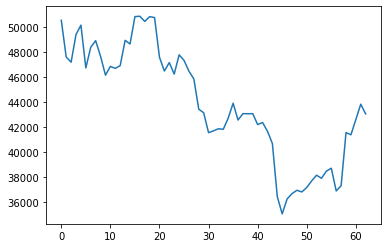

In [43]:
plt.plot(data['close_spot'])

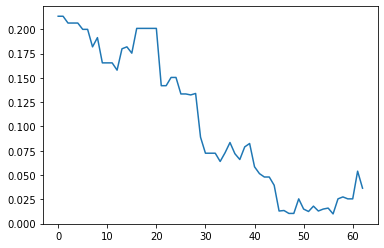

In [44]:
plt.plot(data['close_option'])

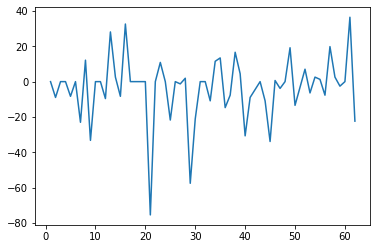

In [41]:
plt.plot(data['daily_pnl_option'])

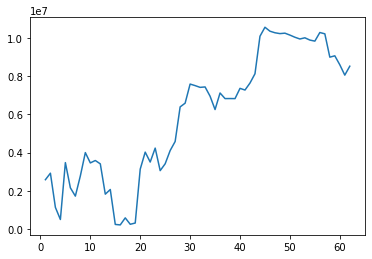

In [32]:
plt.plot(data['pnl'])